In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the DataFrame
df_combined_cleaned = pd.read_csv('df_combined_cleaned_sliding_windows.csv')

ImportError: DLL load failed while importing _imaging: Das angegebene Modul wurde nicht gefunden.

In [2]:
!pip install matplotlib

In [37]:
from sklearn.ensemble import IsolationForest
# Outlier Removal makes it worse

numeric_cols = df_combined_cleaned.select_dtypes(include=[np.number]).columns

iso_forest = IsolationForest(contamination='auto', random_state=42)
#df_combined_cleaned['outlier'] = iso_forest.fit_predict(df_combined_cleaned[numeric_cols])

# Filter out the outliers
#df_cleaned_no_outliers = df_combined_cleaned[df_combined_cleaned['outlier'] != -1]

# Drop the 'outlier' column
#df_combined_cleaned = df_cleaned_no_outliers.drop(columns=['outlier'])

In [38]:
df_combined_cleaned.drop(columns=['Session'], inplace=True)

X = df_combined_cleaned.drop(columns=['profit_loss_cum'])
y = df_combined_cleaned['profit_loss_cum']

categorical_columns = ['Participant', 'Group', 'Type']
numerical_columns = X.columns.difference(categorical_columns)

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Define the preprocessor with StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  # keep the label encoded columns as they are
)

# Apply the preprocessor to the features
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=numerical_columns.tolist() + categorical_columns)

# Convert the target to binary classification
y_binary = (y > 0).astype(int)
y.index = X_preprocessed_df.index


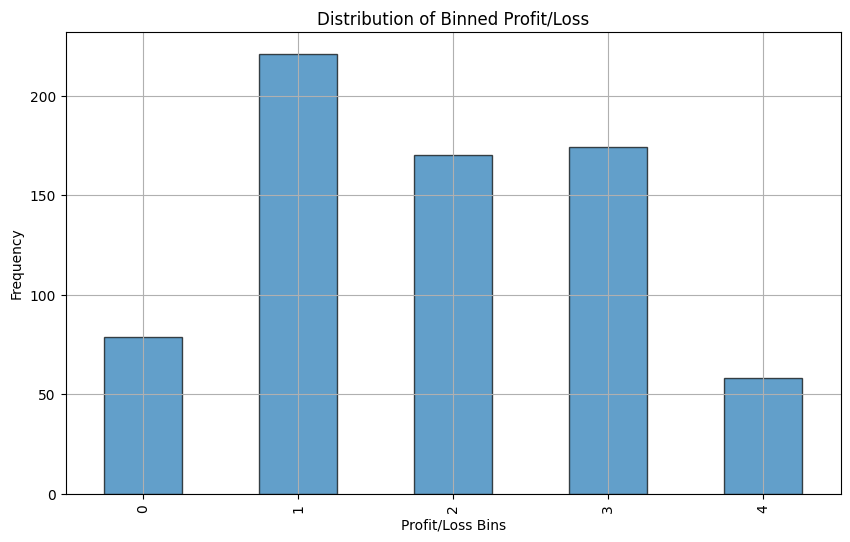

profit_loss_cum
 13.87    2
 39.82    2
 10.31    2
 13.96    2
 20.13    2
         ..
 24.42    1
-2.83     1
 11.55    1
 18.23    1
 21.03    1
Name: count, Length: 696, dtype: int64 profit_loss_cum
1    221
3    174
2    170
0     79
4     58
Name: count, dtype: int64


In [51]:
# Define bins and labels for the classes
bins = [-float('inf'), 0, 20, 40, 100, float('inf')]
labels = [0, 1, 2, 3, 4]

# Create a new column for the binned target
y_binned = pd.cut(y, bins=bins, labels=labels, right=False)

# Show the distribution of the binned target variable
plt.figure(figsize=(10, 6))
y_binned.value_counts().sort_index().plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Distribution of Binned Profit/Loss')
plt.xlabel('Profit/Loss Bins')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(y.value_counts(), y_binned.value_counts())

# Now y_binned contains the target labels for machine learning
y_binned = y_binned.astype(int) 

In [40]:
def custom_train_test_split(X, y, participant_column, test_size=0.2, val_size=0.1, random_state=42):
    unique_participants = X[participant_column].unique()
    
    # Split participants into train+val and test participants
    train_val_participants, test_participants = train_test_split(
        unique_participants, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    # Create train+val and test sets based on the participants
    train_val_mask = X[participant_column].isin(train_val_participants)
    test_mask = X[participant_column].isin(test_participants)
    
    X_train_val = X[train_val_mask]
    y_train_val = y[train_val_mask]
    
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    # Further split train+val into train and val
    unique_train_val_participants = X_train_val[participant_column].unique()
    train_participants, val_participants = train_test_split(
        unique_train_val_participants, test_size=val_size, random_state=random_state, shuffle=True
    )
    
    train_mask = X_train_val[participant_column].isin(train_participants)
    val_mask = X_train_val[participant_column].isin(val_participants)
    
    X_train = X_train_val[train_mask]
    y_train = y_train_val[train_mask]
    
    X_val = X_train_val[val_mask]
    y_val = y_train_val[val_mask]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Apply the custom split function
X_train_df, X_val_df, X_test_df, y_train_df, y_val_df, y_test_df = custom_train_test_split(
    X_preprocessed_df, y, participant_column='Participant', test_size=0.15, val_size=0.15, random_state=42
)

print(f"Training set size: {X_train_df.shape[0]} samples")
print(f"Validation set size: {X_val_df.shape[0]} samples")
print(f"Test set size: {X_test_df.shape[0]} samples")

# Verify that there are no participants in the test set that are in the training set
train_participants = X_train_df['Participant'].unique()
val_participants = X_val_df['Participant'].unique()
test_participants = X_test_df['Participant'].unique()

unique_to_test = set(test_participants) - set(train_participants) - set(val_participants)

print(f"Participants in the training set: {train_participants}")
print(f"Participants in the validation set: {val_participants}")
print(f"Participants in the test set: {test_participants}")
print(f"Participants in the test set but not in the training or validation set: {unique_to_test}")

Training set size: 510 samples
Validation set size: 84 samples
Test set size: 108 samples
Participants in the training set: [36.  5. 23.  3. 11. 12. 33. 35. 30. 21. 26.  8.  9.  0. 19.  1. 15.  4.
 24. 16. 34. 32. 27. 17. 10. 14.]
Participants in the validation set: [ 2. 31.  7. 28. 18.]
Participants in the test set: [25. 22. 29. 13.  6. 20.]
Participants in the test set but not in the training or validation set: {6.0, 13.0, 20.0, 22.0, 25.0, 29.0}


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Prepare the data for model training
X_train = X_train_df.drop(columns=['Participant'])
X_val = X_val_df.drop(columns=['Participant'])
X_test = X_test_df.drop(columns=['Participant'])
y_train = y_train_df
y_val = y_val_df
y_test = y_test_df

# Define hyperparameter grids for each model
param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0, 200, 1000, 2000]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'GradientBoosting': {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.001, 0.01, 0.1, 0.2]},
    'SVR': {'C': [1, 10, 100, 200], 'epsilon': [0.1, 0.2, 0.5, 1, 1.5, 2]},
    'XGBRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9]},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,), (100, 100)], 'alpha': [0.0001, 0.001, 0.01]}
}

# Initialize models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'XGBRegressor': XGBRegressor(),
    'MLPRegressor': MLPRegressor(max_iter=1000)
}

# Perform Grid Search for each model
best_models = {}
for name, model in models.items():
    print(f"Performing grid search for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models on the validation set
results = {}
for name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    results[name] = {
        'MSE': mse_val,
        'RMSE': rmse_val,
        'MAE': mae_val,
        'R2': r2_val
    }
    print(f"{name} - Validation Metrics: MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")

# Select the best model based on validation performance
best_model_name = min(results, key=lambda k: results[k]['MSE'])
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name}")

# Optionally, evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Metrics for {best_model_name}: MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")


Performing grid search for Ridge...
Best parameters for Ridge: {'alpha': 0.1}
Performing grid search for Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Performing grid search for ElasticNet...


C:\Users\janim\miniconda3\envs\master\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e+05, tolerance: 1.087e+02
  model = cd_fast.enet_coordinate_descent(


Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.8}
Performing grid search for RandomForest...
Best parameters for RandomForest: {'max_depth': 30, 'n_estimators': 200}
Performing grid search for GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'n_estimators': 200}
Performing grid search for SVR...
Best parameters for SVR: {'C': 200, 'epsilon': 2}
Performing grid search for XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Performing grid search for MLPRegressor...
Best parameters for MLPRegressor: {'alpha': 0.001, 'hidden_layer_sizes': (100, 100)}
Ridge - Validation Metrics: MSE: 6227.0755, RMSE: 78.9118, MAE: 64.0760, R2: -0.5365
Lasso - Validation Metrics: MSE: 5681.2948, RMSE: 75.3744, MAE: 61.1385, R2: -0.4018
ElasticNet - Validation Metrics: MSE: 4751.3246, RMSE: 68.9299, MAE: 51.8810, R2: -0.1724
RandomForest - Validation Metrics: MSE: 5290.3547, RMSE: 72.7348, MAE: 52.7085, R2

In [22]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the performance metrics
print(f"Best Model ({best_model_name}) - Test Metrics: MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")

Best Model (XGBRegressor) - Test Metrics: MSE: 5032.7271, RMSE: 70.9417, MAE: 49.7143, R2: -0.1138


### WITH DATA EXPANSION TECHNIQUES

In [41]:
# Function to add Gaussian noise to the numerical columns
def add_gaussian_noise(X, columns, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X[columns].shape)
    X[columns] += noise
    return X

numerical_columns = X_train_df.columns.difference(categorical_columns)

num_augmented_samples = len(X_train_df)

# Create augmented training data by duplicating the original training data
X_train_augmented = pd.concat([X_train_df] * 2, ignore_index=True)
y_train_augmented = pd.concat([y_train_df] * 2, ignore_index=True)

# Add Gaussian noise to the duplicated portion of the training data
X_train_augmented.iloc[num_augmented_samples:] = add_gaussian_noise(X_train_augmented.iloc[num_augmented_samples:], numerical_columns)

# Verify the sizes of the datasets after augmentation
print(f"Training set size (original): {X_train_df.shape[0]} samples")
print(f"Training set size (augmented): {X_train_augmented.shape[0]} samples")
print(f"Validation set size: {X_val_df.shape[0]} samples")
print(f"Test set size: {X_test_df.shape[0]} samples")

# Verify that there are no participants in the test set that are in the training set
train_participants = X_train_augmented['Participant'].unique()
val_participants = X_val_df['Participant'].unique()
test_participants = X_test_df['Participant'].unique()

unique_to_test = set(test_participants) - set(train_participants) - set(val_participants)

print(f"Participants in the training set (augmented): {train_participants}")
print(f"Participants in the validation set: {val_participants}")
print(f"Participants in the test set: {test_participants}")
print(f"Participants in the test set but not in the training or validation set: {unique_to_test}")

Training set size (original): 510 samples
Training set size (augmented): 1020 samples
Validation set size: 84 samples
Test set size: 108 samples
Participants in the training set (augmented): [36.  5. 23.  3. 11. 12. 33. 35. 30. 21. 26.  8.  9.  0. 19.  1. 15.  4.
 24. 16. 34. 32. 27. 17. 10. 14.]
Participants in the validation set: [ 2. 31.  7. 28. 18.]
Participants in the test set: [25. 22. 29. 13.  6. 20.]
Participants in the test set but not in the training or validation set: {6.0, 13.0, 20.0, 22.0, 25.0, 29.0}


C:\Users\janim\AppData\Local\Temp\ipykernel_21364\3728978892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[columns] += noise


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

X_train = X_train_augmented.drop(columns=['Participant'])
X_val = X_val_df.drop(columns=['Participant'])
X_test = X_test_df.drop(columns=['Participant'])
y_train = y_train_augmented
y_val = y_val_df
y_test = y_test_df

param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0, 200, 1000, 2000]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'GradientBoosting': {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.001, 0.01, 0.1, 0.2]},
    'SVR': {'C': [1, 10, 100, 200], 'epsilon': [0.1, 0.2, 0.5, 1, 1.5, 2]},
    'XGBRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9, 12]},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,), (100, 100)], 'alpha': [0.0001, 0.001, 0.01]}
}

# Initialize models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'XGBRegressor': XGBRegressor(),
    'MLPRegressor': MLPRegressor(max_iter=10000)
}

# Perform Grid Search for each model
best_models = {}
for name, model in models.items():
    print(f"Performing grid search for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models on the validation set
results = {}
for name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    results[name] = {
        'MSE': mse_val,
        'RMSE': rmse_val,
        'MAE': mae_val,
        'R2': r2_val
    }
    print(f"{name} - Validation Metrics: MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")

# Select the best model based on validation performance
best_model_name = min(results, key=lambda k: results[k]['MSE'])
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name}")

# Optionally, evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Metrics for {best_model_name}: MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")


Performing grid search for Ridge...
Best parameters for Ridge: {'alpha': 0.1}
Performing grid search for Lasso...


C:\Users\janim\miniconda3\envs\master\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.082e+05, tolerance: 2.173e+02
  model = cd_fast.enet_coordinate_descent(


Best parameters for Lasso: {'alpha': 0.01}
Performing grid search for ElasticNet...
Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.8}
Performing grid search for RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 200}
Performing grid search for GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 500}
Performing grid search for SVR...
Best parameters for SVR: {'C': 200, 'epsilon': 2}
Performing grid search for XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Performing grid search for MLPRegressor...
Best parameters for MLPRegressor: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100)}
Ridge - Validation Metrics: MSE: 6537.3673, RMSE: 80.8540, MAE: 65.9193, R2: -0.6131
Lasso - Validation Metrics: MSE: 5609.4093, RMSE: 74.8960, MAE: 60.8237, R2: -0.3841
ElasticNet - Validation Metrics: MSE: 4751.9652, RMSE: 68.9345, MAE: 51.8887, R2: -0.

Best Model (XGBRegressor) - Test Metrics: MSE: 4994.7238, RMSE: 70.6734, MAE: 50.3837, R2: -0.1054


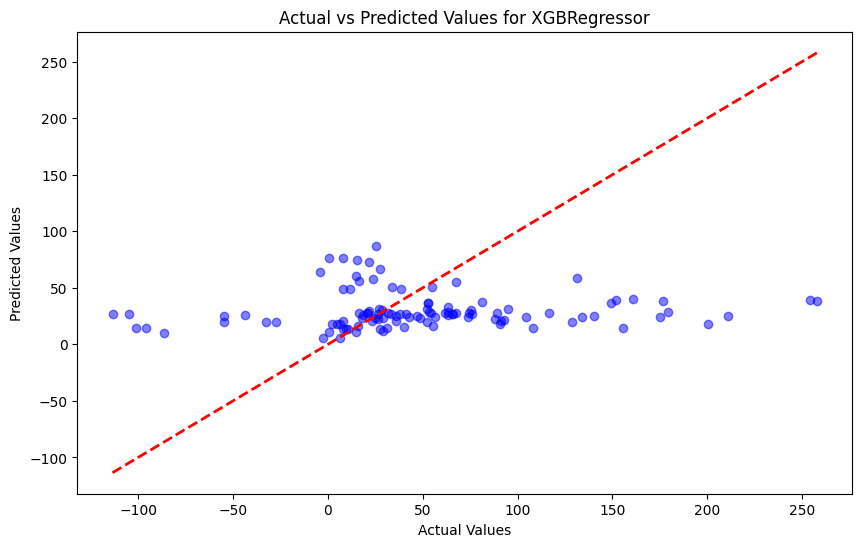

In [48]:
import matplotlib.pyplot as plt

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the performance metrics
print(f"Best Model ({best_model_name}) - Test Metrics: MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")

# Create a scatter plot for actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values for {best_model_name}')
plt.show()


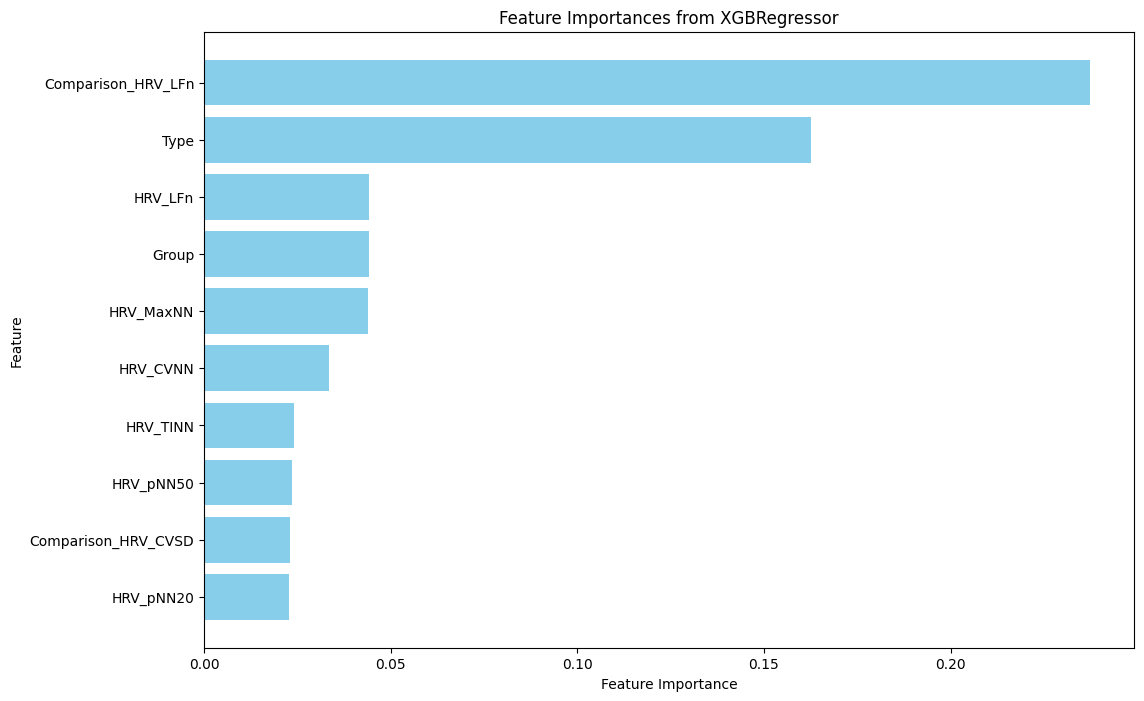

In [50]:
# Assuming X_train has the feature names
feature_names = X_train.columns

# Access the feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBRegressor')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

### STACKING

In [44]:
best_models

{'Ridge': Ridge(alpha=0.1),
 'Lasso': Lasso(alpha=0.01),
 'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.8),
 'RandomForest': RandomForestRegressor(n_estimators=200),
 'GradientBoosting': GradientBoostingRegressor(n_estimators=500),
 'SVR': SVR(C=200, epsilon=2),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tr

In [47]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('ElasticNet', best_models['ElasticNet']),
    ('RandomForest', best_models['RandomForest']),
    ('XGBRegressor', best_models['XGBRegressor']),
    ('MLPRegressor', best_models['MLPRegressor'])
]

# Define the meta-model
meta_model = XGBRegressor()

# Create the stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=5)

# Fit the stacking model to the training data
stacking_model.fit(X_train, y_train)

# Evaluate the stacking model on the validation set
y_val_pred = stacking_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"Stacking Model - Validation Metrics: MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")

# Evaluate the stacking model on the test set
y_test_pred = stacking_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Metrics for Stacking Model: MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")

KeyboardInterrupt: 

### CATEGORICAL 

In [52]:
# Custom train-test split function
def custom_train_test_split(X, y, participant_column, test_size=0.2, val_size=0.1, random_state=42):
    unique_participants = X[participant_column].unique()
    
    # Split participants into train+val and test participants
    train_val_participants, test_participants = train_test_split(
        unique_participants, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    # Create train+val and test sets based on the participants
    train_val_mask = X[participant_column].isin(train_val_participants)
    test_mask = X[participant_column].isin(test_participants)
    
    X_train_val = X[train_val_mask]
    y_train_val = y[train_val_mask]
    
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    # Further split train+val into train and val
    unique_train_val_participants = X_train_val[participant_column].unique()
    train_participants, val_participants = train_test_split(
        unique_train_val_participants, test_size=val_size, random_state=random_state, shuffle=True
    )
    
    train_mask = X_train_val[participant_column].isin(train_participants)
    val_mask = X_train_val[participant_column].isin(val_participants)
    
    X_train = X_train_val[train_mask]
    y_train = y_train_val[train_mask]
    
    X_val = X_train_val[val_mask]
    y_val = y_train_val[val_mask]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Apply the custom split function
X_train_df, X_val_df, X_test_df, y_train_df, y_val_df, y_test_df = custom_train_test_split(
    X_preprocessed_df, y_binned, participant_column='Participant', test_size=0.15, val_size=0.15, random_state=42
)

print(f"Training set size: {X_train_df.shape[0]} samples")
print(f"Validation set size: {X_val_df.shape[0]} samples")
print(f"Test set size: {X_test_df.shape[0]} samples")

# Verify that there are no participants in the test set that are in the training set
train_participants = X_train_df['Participant'].unique()
val_participants = X_val_df['Participant'].unique()
test_participants = X_test_df['Participant'].unique()

unique_to_test = set(test_participants) - set(train_participants) - set(val_participants)

print(f"Participants in the training set: {train_participants}")
print(f"Participants in the validation set: {val_participants}")
print(f"Participants in the test set: {test_participants}")
print(f"Participants in the test set but not in the training or validation set: {unique_to_test}")


Training set size: 510 samples
Validation set size: 84 samples
Test set size: 108 samples
Participants in the training set: [36.  5. 23.  3. 11. 12. 33. 35. 30. 21. 26.  8.  9.  0. 19.  1. 15.  4.
 24. 16. 34. 32. 27. 17. 10. 14.]
Participants in the validation set: [ 2. 31.  7. 28. 18.]
Participants in the test set: [25. 22. 29. 13.  6. 20.]
Participants in the test set but not in the training or validation set: {6.0, 13.0, 20.0, 22.0, 25.0, 29.0}


In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [64]:
# Prepare the data for model training
X_train_cat = X_train_df.drop(columns=['Participant'])
X_val_cat = X_val_df.drop(columns=['Participant'])
X_test_cat = X_test_df.drop(columns=['Participant'])
y_train_cat = y_train_df
y_val_cat = y_val_df
y_test_cat = y_test_df


In [55]:
# Define hyperparameter grids for each model
param_grids = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 100]},
    'SVC': {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'RandomForest': {'n_estimators': [50, 100, 200, 400], 'max_depth': [None, 10, 20, 30]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'KNeighbors': {'n_neighbors': [3, 5, 7, 9]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(probability=True),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNeighbors': KNeighborsClassifier()
}

# Perform Grid Search for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_cat, y_train_cat)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Best parameters for LogisticRegression: {'C': 100}
Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 400}
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'n_estimators': 100}
Best parameters for KNeighbors: {'n_neighbors': 3}


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [65]:

# Evaluate the best models on the validation set
results = {}
for name, model in best_models.items():
    y_val_pred = model.predict(X_val_cat)
    accuracy_val = accuracy_score(y_val_cat, y_val_pred)
    precision_val = precision_score(y_val_cat, y_val_pred, average='macro')
    recall_val = recall_score(y_val_cat, y_val_pred, average='macro')
    f1_val = f1_score(y_val_cat, y_val_pred, average='macro')
    roc_auc_val = roc_auc_score(y_val_cat, model.predict_proba(X_val), multi_class='ovr', average='macro')
    results[name] = {
        'Accuracy': accuracy_val,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1': f1_val,
        'ROC AUC': roc_auc_val
    }
    print(f"{name} - Validation Metrics: Accuracy: {accuracy_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}, ROC AUC: {roc_auc_val:.4f}")

# Select the best model based on validation performance
best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name}")

LogisticRegression - Validation Metrics: Accuracy: 0.1905, Precision: 0.1854, Recall: 0.1725, F1: 0.1666, ROC AUC: 0.5227
SVC - Validation Metrics: Accuracy: 0.1786, Precision: 0.1911, Recall: 0.1969, F1: 0.1548, ROC AUC: 0.5341
RandomForest - Validation Metrics: Accuracy: 0.1905, Precision: 0.2038, Recall: 0.2185, F1: 0.1527, ROC AUC: 0.5551
GradientBoosting - Validation Metrics: Accuracy: 0.2381, Precision: 0.1909, Recall: 0.2226, F1: 0.1706, ROC AUC: 0.5397
KNeighbors - Validation Metrics: Accuracy: 0.2619, Precision: 0.2264, Recall: 0.2651, F1: 0.1978, ROC AUC: 0.5365
Best Model: KNeighbors


C:\Users\janim\miniconda3\envs\master\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\janim\miniconda3\envs\master\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\janim\miniconda3\envs\master\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C

Test Metrics: Accuracy: 0.2315, Precision: 0.2084, Recall: 0.2032, F1: 0.1735, ROC AUC: 0.5590


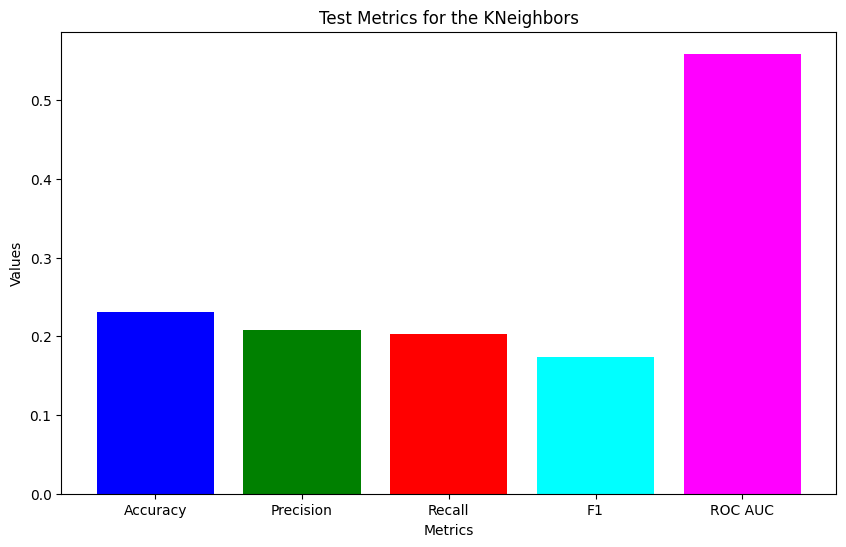

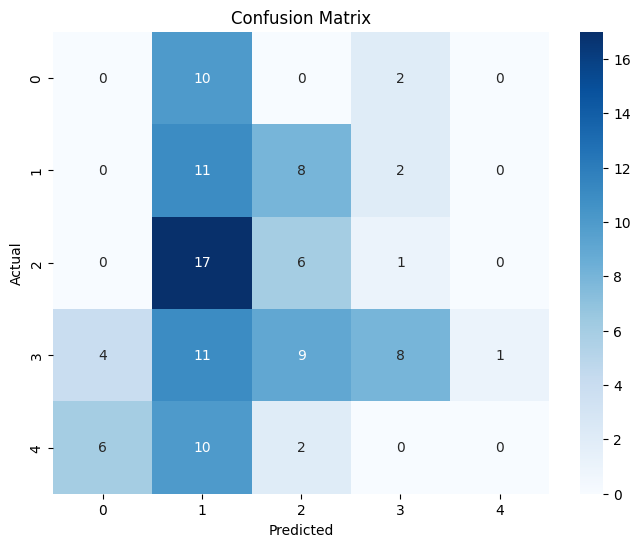

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.19      0.52      0.28        21
           2       0.24      0.25      0.24        24
           3       0.62      0.24      0.35        33
           4       0.00      0.00      0.00        18

    accuracy                           0.23       108
   macro avg       0.21      0.20      0.17       108
weighted avg       0.28      0.23      0.21       108



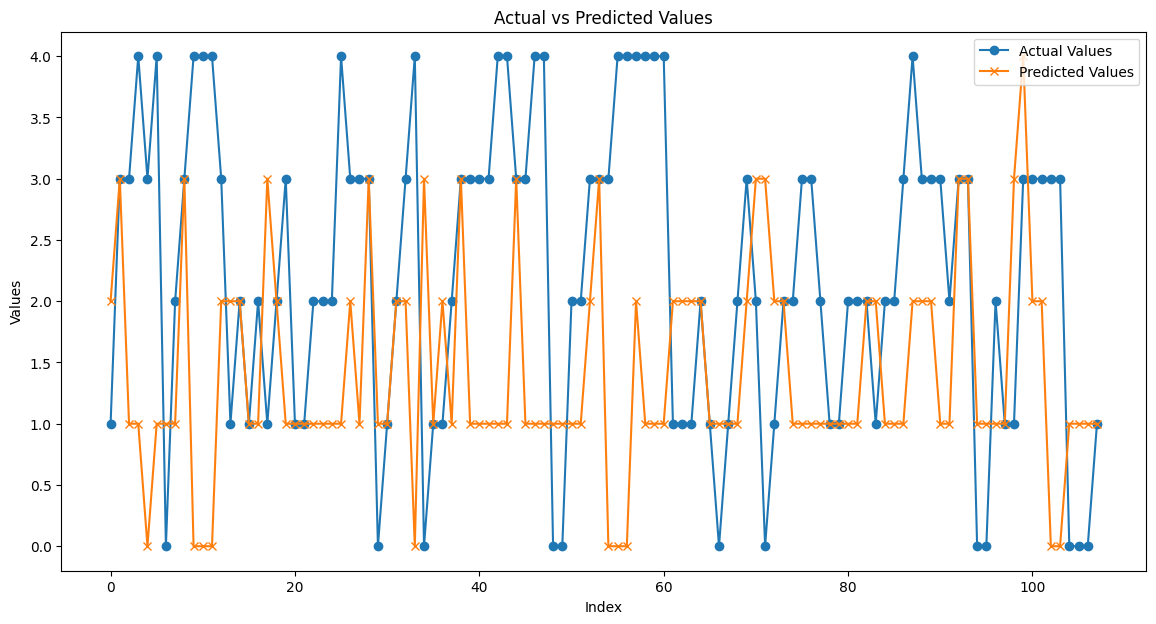

In [67]:
# Retrain the best model on the combined training and validation set
X_train_val_combined = pd.concat([X_train_cat, X_val_cat])
y_train_val_combined = pd.concat([y_train_cat, y_val_cat])
best_model.fit(X_train_val_combined, y_train_val_combined)

# Predict on the test set
y_test_pred = best_model.predict(X_test_cat)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test_cat, y_test_pred)
precision_test = precision_score(y_test_cat, y_test_pred, average='macro')
recall_test = recall_score(y_test_cat, y_test_pred, average='macro')
f1_test = f1_score(y_test_cat, y_test_pred, average='macro')
roc_auc_test = roc_auc_score(y_test_cat, best_model.predict_proba(X_test_cat), multi_class='ovr', average='macro')

print(f"Test Metrics: Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1: {f1_test:.4f}, ROC AUC: {roc_auc_test:.4f}")

# Plotting the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
values = [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'cyan', 'magenta'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics for the KNeighbors')
plt.show()

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test_cat, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_cat, y_test_pred))

# Plotting the actual and predicted values as lines
plt.figure(figsize=(14, 7))
plt.plot(y_test_cat.reset_index(drop=True), label='Actual Values', linestyle='-', marker='o')
plt.plot(pd.Series(y_test_pred), label='Predicted Values', linestyle='-', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()